- 정상과 이상에 대한 정확한 라벨이 없기 때문에 지도학습, 준지도학습 알고리즘은 시도할 수 없다.
- 따라서 비지도학습 알고리즘인 AutoEncoder 알고리즘과 이에 파생되는 알고리즘들을 적용하여 비교해볼 것이다.

# AutoEncoder

- 일반 데이터

# CNN-AutoEncoder

- 이미지 변환 데이터

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import json

## 1. 데이터 불러오기

- 우선 return_air_temperature만 해보자!

In [3]:
batch_size = 256
learning_rate = 0.0002
num_epoch = 50

In [4]:
#mnist_train = dset.MNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)

In [5]:
#mnist_train

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
with open("../data/image_data.json", "r") as f:
    image_data = json.load(f)

In [5]:
image_data.keys()

dict_keys(['gasf_at', 'gasf_rat', 'gasf_sat', 'gadf_at', 'gadf_rat', 'gadf_sat'])

In [6]:
gadf_rat = image_data['gadf_rat']

In [7]:
aa = []
for i in gadf_rat:
    aa.append(torch.FloatTensor([i]))

In [8]:
aa = tuple(aa)

In [9]:
train_loader = DataLoader(aa,batch_size=batch_size, shuffle=True,num_workers=2,drop_last=True)
# test_loader = DataLoader(test,batch_size=batch_size, shuffle=False,num_workers=2,drop_last=True)

In [10]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1,16,3,padding=1), # batch x 16 x 24 x 24
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Conv2d(16,32,3,padding=1), # batch x 32 x 24 x 24
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32,64,3,padding=1), # batch x 64 x 24 x 24
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.MaxPool2d(2,2) # batch x 64 x 12 x 12
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(64,128,3,padding=1), # batch x 128 x 12 x 12
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.MaxPool2d(2,2),
                        nn.Conv2d(128,256,3,padding=1), # batch x 256 x 6 x 6
                        nn.ReLU()
        )
        
                
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(batch_size, -1)
        return out

In [30]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.ConvTranspose2d(256,128,3,2,1,1), # batch x 128 x 12 x 12
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(128,64,3,1,1), # batch x 64 x 12 x 12
                        nn.ReLU(),
                        nn.BatchNorm2d(64)
        )
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(64,16,3,1,1), # batch x 16 x 12 x 12
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.ConvTranspose2d(16,1,3,2,1,1), # batch x 1 x 24 x 24
                        nn.ReLU()
        )
        
    def forward(self,x):
        out = x.view(batch_size,256,6,6)
        out = self.layer1(out)
        out = self.layer2(out)
        return out

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

encoder = Encoder().to(device)
decoder = Decoder().to(device)

# 인코더 디코더의 파라미터를 동시에 학습시키기 위해 이를 묶는 방법입니다.
parameters = list(encoder.parameters())+ list(decoder.parameters())

loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)

cpu


In [15]:
from tqdm import tqdm

train_loss_log = []
for i in range(num_epoch):
    train_loss = []
    for image in tqdm(train_loader):
        optimizer.zero_grad()
        image = image.to(device)
        
        output = encoder(image)
        output = decoder(output)
        
        loss = loss_func(output,image)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
    print(f"{i} epochs loss: {np.mean(train_loss)}")
    train_loss_log.append(np.mean(train_loss))

100%|██████████| 3/3 [00:05<00:00,  1.95s/it]


0 epochs loss: 0.6166940828164419


100%|██████████| 3/3 [00:05<00:00,  1.90s/it]


1 epochs loss: 0.3752625783284505


100%|██████████| 3/3 [00:05<00:00,  1.85s/it]


2 epochs loss: 0.31693147619565326


100%|██████████| 3/3 [00:05<00:00,  1.84s/it]


3 epochs loss: 0.2893660267194112


100%|██████████| 3/3 [00:05<00:00,  1.82s/it]


4 epochs loss: 0.273507962624232


100%|██████████| 3/3 [00:05<00:00,  1.83s/it]


5 epochs loss: 0.26771315932273865


100%|██████████| 3/3 [00:05<00:00,  1.85s/it]


6 epochs loss: 0.26222914457321167


100%|██████████| 3/3 [00:05<00:00,  1.85s/it]


7 epochs loss: 0.25473836064338684


100%|██████████| 3/3 [00:05<00:00,  1.86s/it]


8 epochs loss: 0.24952914317448935


100%|██████████| 3/3 [00:05<00:00,  1.85s/it]


9 epochs loss: 0.24656865000724792


100%|██████████| 3/3 [00:05<00:00,  1.84s/it]


10 epochs loss: 0.24198285738627115


100%|██████████| 3/3 [00:05<00:00,  1.86s/it]


11 epochs loss: 0.2404095580180486


100%|██████████| 3/3 [00:05<00:00,  1.86s/it]


12 epochs loss: 0.23641799887021384


100%|██████████| 3/3 [00:05<00:00,  1.83s/it]


13 epochs loss: 0.23379562298456827


100%|██████████| 3/3 [00:05<00:00,  1.86s/it]


14 epochs loss: 0.22976534565289816


100%|██████████| 3/3 [00:05<00:00,  1.84s/it]


15 epochs loss: 0.2285791834195455


100%|██████████| 3/3 [00:05<00:00,  1.86s/it]


16 epochs loss: 0.2274235635995865


100%|██████████| 3/3 [00:05<00:00,  1.83s/it]


17 epochs loss: 0.2242532273133596


100%|██████████| 3/3 [00:05<00:00,  1.85s/it]


18 epochs loss: 0.22275593876838684


100%|██████████| 3/3 [00:05<00:00,  1.86s/it]


19 epochs loss: 0.22222205499807993


100%|██████████| 3/3 [00:05<00:00,  1.85s/it]


20 epochs loss: 0.22062471508979797


100%|██████████| 3/3 [00:05<00:00,  1.90s/it]


21 epochs loss: 0.21932203571001688


100%|██████████| 3/3 [00:05<00:00,  1.88s/it]


22 epochs loss: 0.21890814105669656


100%|██████████| 3/3 [00:05<00:00,  1.86s/it]


23 epochs loss: 0.21680505573749542


100%|██████████| 3/3 [00:05<00:00,  1.89s/it]


24 epochs loss: 0.2185443639755249


100%|██████████| 3/3 [00:05<00:00,  1.89s/it]


25 epochs loss: 0.21393044292926788


100%|██████████| 3/3 [00:05<00:00,  1.86s/it]


26 epochs loss: 0.21553280452887216


100%|██████████| 3/3 [00:05<00:00,  1.89s/it]


27 epochs loss: 0.21368622283140817


100%|██████████| 3/3 [00:05<00:00,  1.87s/it]


28 epochs loss: 0.21284841001033783


100%|██████████| 3/3 [00:05<00:00,  1.86s/it]


29 epochs loss: 0.2108501543601354


100%|██████████| 3/3 [00:05<00:00,  1.90s/it]


30 epochs loss: 0.21357246239980063


100%|██████████| 3/3 [00:05<00:00,  1.88s/it]


31 epochs loss: 0.2119208425283432


100%|██████████| 3/3 [00:05<00:00,  1.88s/it]


32 epochs loss: 0.21164172887802124


100%|██████████| 3/3 [00:05<00:00,  1.87s/it]


33 epochs loss: 0.21025991439819336


100%|██████████| 3/3 [00:05<00:00,  1.88s/it]


34 epochs loss: 0.2095726082722346


100%|██████████| 3/3 [00:05<00:00,  1.88s/it]


35 epochs loss: 0.2118516912062963


100%|██████████| 3/3 [00:05<00:00,  1.86s/it]


36 epochs loss: 0.2084040343761444


100%|██████████| 3/3 [00:05<00:00,  1.89s/it]


37 epochs loss: 0.20778054495652518


100%|██████████| 3/3 [00:05<00:00,  1.86s/it]


38 epochs loss: 0.20690265794595084


100%|██████████| 3/3 [00:05<00:00,  1.89s/it]


39 epochs loss: 0.20638481279214224


100%|██████████| 3/3 [00:05<00:00,  1.92s/it]


40 epochs loss: 0.20505645871162415


100%|██████████| 3/3 [00:05<00:00,  1.89s/it]


41 epochs loss: 0.20534156262874603


100%|██████████| 3/3 [00:05<00:00,  1.90s/it]


42 epochs loss: 0.2058432549238205


100%|██████████| 3/3 [00:05<00:00,  1.86s/it]


43 epochs loss: 0.20431767404079437


100%|██████████| 3/3 [00:05<00:00,  1.89s/it]


44 epochs loss: 0.20280048747857413


100%|██████████| 3/3 [00:05<00:00,  1.90s/it]


45 epochs loss: 0.20696906248728433


100%|██████████| 3/3 [00:05<00:00,  1.87s/it]


46 epochs loss: 0.20790702104568481


100%|██████████| 3/3 [00:05<00:00,  1.88s/it]


47 epochs loss: 0.20462533334891


100%|██████████| 3/3 [00:05<00:00,  1.88s/it]


48 epochs loss: 0.20205088953177133


100%|██████████| 3/3 [00:05<00:00,  1.88s/it]

49 epochs loss: 0.20311353107293448


In [24]:
# 학습이 끝난 모델 저장
torch.save(encoder.state_dict(), "./ce_50.pt")
torch.save(decoder.state_dict(), "./cd_50.pt")

torch.Size([256, 24, 24])


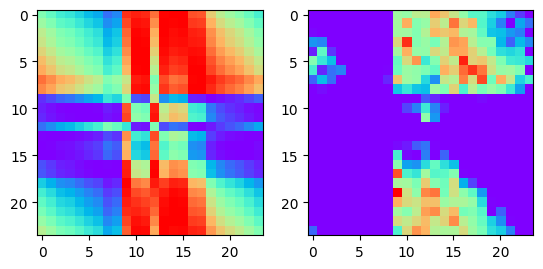

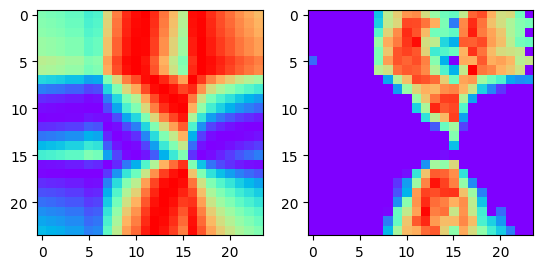

In [19]:
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(2):
    plt.subplot(1,2,1)
    plt.imshow(torch.squeeze(image[i]).cpu().numpy(),cmap='rainbow')
    plt.subplot(1,2,2)
    plt.imshow(out_img[i].numpy(),cmap='rainbow')
    plt.show()

In [33]:
aa = []
for i in gadf_rat:
    image_swap = np.expand_dims([i], axis=0)
    aa.append(torch.FloatTensor(image_swap))

In [38]:
with torch.no_grad():
    for image in aa:
       
        image = image.to(device)
        output = encoder(image)
        output = decoder(output)
        loss = loss_func(output,image)
        print(loss)

RuntimeError: shape '[256, 256, 6, 6]' is invalid for input of size 9216

torch.Size([256, 24, 24])


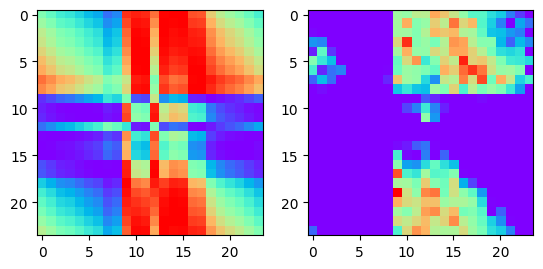

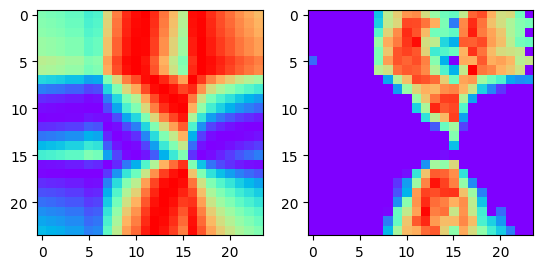

In [23]:
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(2):
    plt.subplot(1,2,1)
    plt.imshow(torch.squeeze(image[i]).cpu().numpy(),cmap='rainbow')
    plt.subplot(1,2,2)
    plt.imshow(out_img[i].numpy(),cmap='rainbow')
    plt.show()

# LSTM-AutoEncoder

- 일반 데이터에 시계열을 제거하지 않은 데이터(=시계열 데이터)